In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [7]:
df = pd.read_csv("global_water_consumption.csv")
print("Original Shape:", df.shape)
df.head()

Original Shape: (500, 10)


,Country,Year,Total Water Consumption (Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%),Water Scarcity Level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate


In [8]:
print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nSummary Statistics:")
print(df.describe(include="all"))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Country                                         500 non-null    object 
 1   Year                                            500 non-null    int64  
 2   Total Water Consumption (Billion Cubic Meters)  500 non-null    float64
 3   Per Capita Water Use (Liters per Day)           500 non-null    float64
 4   Agricultural Water Use (%)                      500 non-null    float64
 5   Industrial Water Use (%)                        500 non-null    float64
 6   Household Water Use (%)                         500 non-null    float64
 7   Rainfall Impact (Annual Precipitation in mm)    500 non-null    float64
 8   Groundwater Depletion Rate (%)                  500 non-null    float64
 9   Water Scarcity Level        

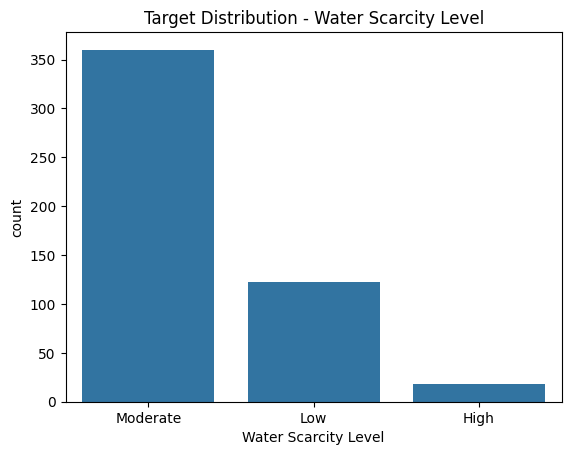

In [9]:
sns.countplot(x="Water Scarcity Level", data=df)
plt.title("Target Distribution - Water Scarcity Level")
plt.show()

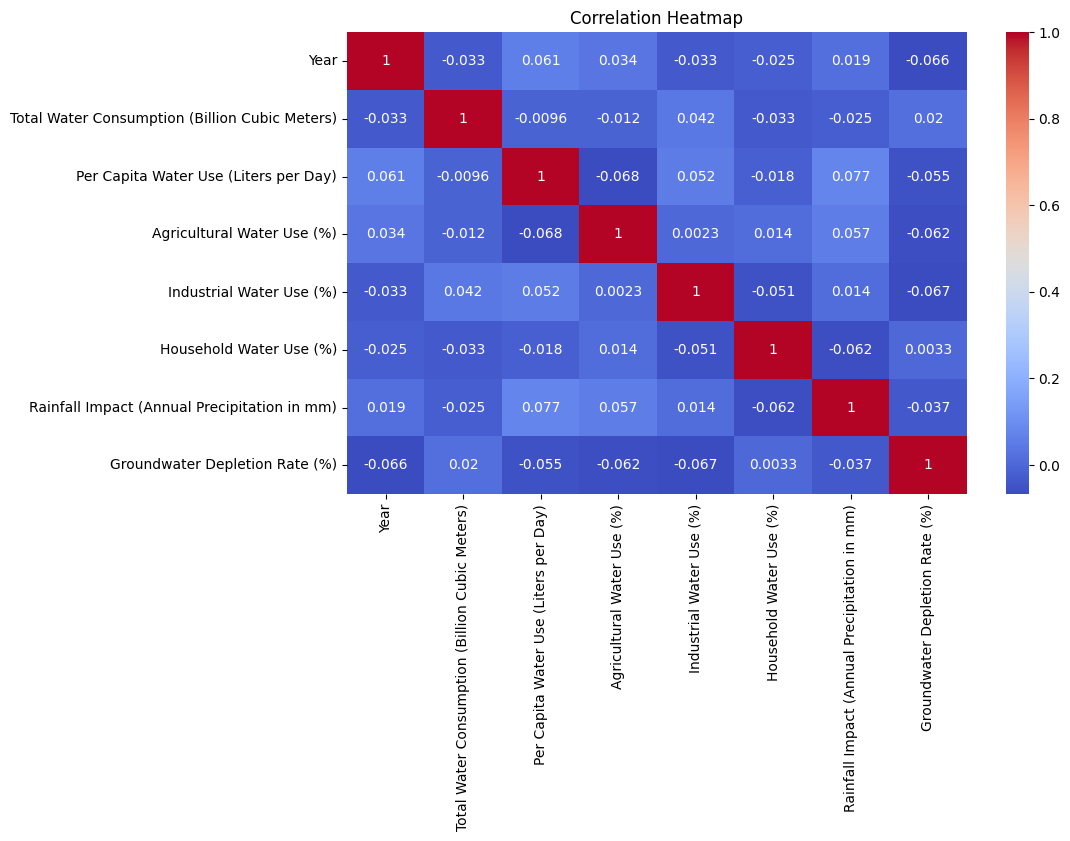

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

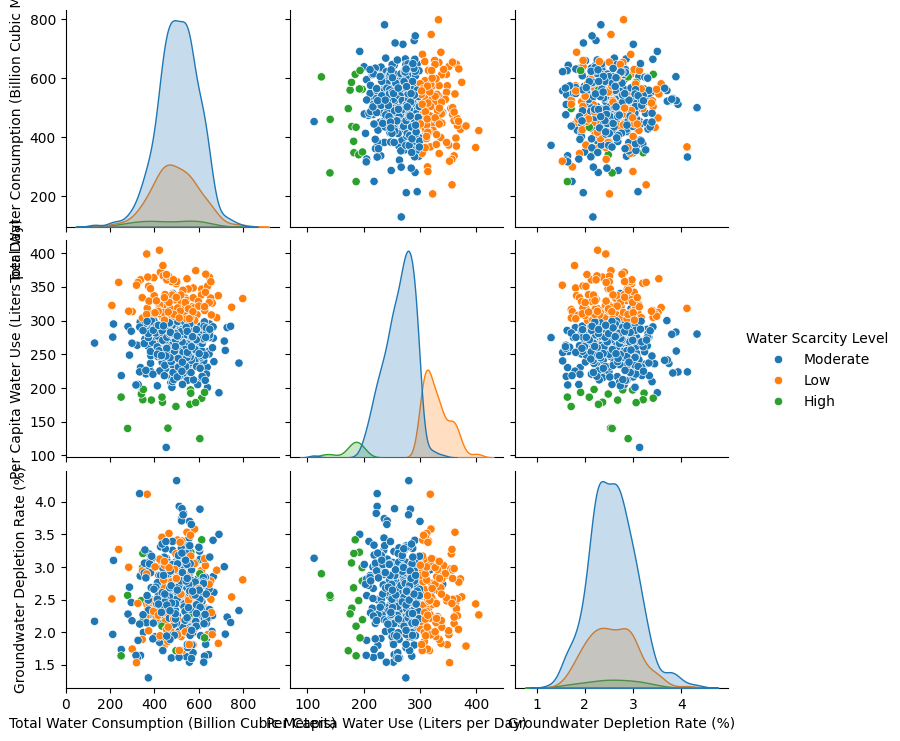

In [11]:
sns.pairplot(df[["Total Water Consumption (Billion Cubic Meters)",
                 "Per Capita Water Use (Liters per Day)",
                 "Groundwater Depletion Rate (%)",
                 "Water Scarcity Level"]],
             hue="Water Scarcity Level")
plt.show()

In [12]:
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

After removing duplicates: (500, 10)


In [13]:
le = LabelEncoder()
df["Water Scarcity Level"] = le.fit_transform(df["Water Scarcity Level"])
print("Target Classes Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
df = pd.get_dummies(df, columns=["Country"], drop_first=True)

Target Classes Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}


In [14]:
Q1 = df["Per Capita Water Use (Liters per Day)"].quantile(0.25)
Q3 = df["Per Capita Water Use (Liters per Day)"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["Per Capita Water Use (Liters per Day)"] >= Q1 - 1.5*IQR) &
        (df["Per Capita Water Use (Liters per Day)"] <= Q3 + 1.5*IQR)]

In [15]:
X = df.drop("Water Scarcity Level", axis=1)
y = df["Water Scarcity Level"]

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corrwith(y)
print("\nCorrelation of features with target:\n", corr_matrix.sort_values(ascending=False))


Correlation of features with target:
 Country_Australia                                 0.081640
Country_South Korea                               0.063456
Country_South Africa                              0.045272
Total Water Consumption (Billion Cubic Meters)    0.044399
Country_Germany                                   0.027088
Country_Japan                                     0.027088
Country_Italy                                     0.025509
Year                                              0.018070
Country_Mexico                                    0.016845
Agricultural Water Use (%)                        0.010798
Country_Spain                                     0.008904
Country_Russia                                    0.008904
Country_China                                     0.008904
Country_Brazil                                    0.008904
Country_India                                     0.005755
Groundwater Depletion Rate (%)                    0.003032
Country_France   

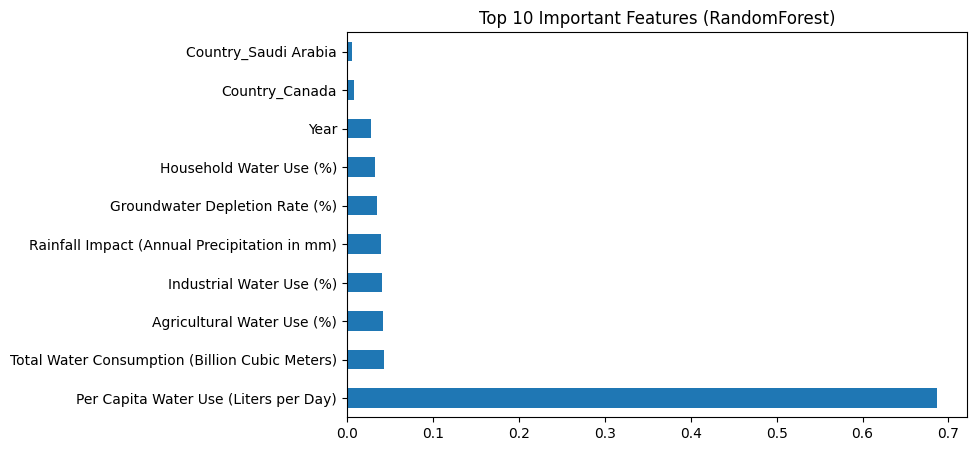

In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,5))
top_features.plot(kind="barh")
plt.title("Top 10 Important Features (RandomForest)")
plt.show()


In [19]:
X_selected = X[top_features.index]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

X_train shape: (393, 27)
X_test shape: (99, 27)
y_train distribution:
 Water Scarcity Level
2    287
1     95
0     11
Name: count, dtype: int64
y_test distribution:
 Water Scarcity Level
2    72
1    24
0     3
Name: count, dtype: int64
